# サプライ・チェイン・リスク分析モジュール scrm とリスク分析システム MERIODAS　

> Supply chain risk analysis system MERIODAS (MEta RIsk Oriented Disruption Analysis System)



In [ ]:
#| default_exp scrm

In [ ]:
#| include: false
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| export
import sys
sys.path.append('..')
from scmopt2.optinv import *
from scmopt2.core import *

#from gurobipy import Model, quicksum, GRB
from mypulp import Model, quicksum, GRB

import numpy as np
import networkx as nx
import plotly.graph_objs as go
import plotly.express as px
import plotly
import pandas as pd
import random
import datetime
import math
from collections import OrderedDict, defaultdict
import networkx as nx
from IPython.display import Image, YouTubeVideo

folder = "./data/scrm/"
folder_bom = "./data/bom/"

## 簡易システムの紹介ビデオ

サプライ・チェイン・リスク分析システム　MERIODAS　(MEta RIsk Oriented Disruption Analysis System)

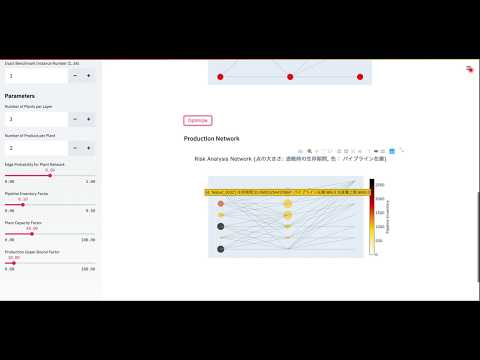

In [ ]:
#| echo: false
YouTubeVideo("9D13CjGXrNM")

## はじめに

我々は通常の生活の中でも様々なリスクに直面している．そして，リスクを回避した行動をとり，リスクに備えて準備をし，万が一に備えて保険をかける．リスクを上手に管理することによって，良い人生を送ることができるからだ．
サプライ・チェインも，我々の人生と同様に，様々なリスクに直面している．リスクを上手に管理することは，
サプライ・チェインの効率化と同様に重要なのだ．
リスクを無視して効率だけを目標としたサプライ・チェインは，
継続性・永続性の意味で弱く，
脆弱なサプライ・チェインであると考えられる．

近年のサプライ・チェインのグローバル化に伴い，リスクは増加しており，
世界で発生する様々なリスクが，サプライ・チェインに大きな影響を与えるようになってきている．
さらに我が国は，地震や津波や台風などの自然災害の危険性が大きく，リスクを無視したサプライ・チェインはギャンブルに他ならない．

サプライ・チェインの効率性だけでなく，リスクを考慮して柔軟かつ頑強なサプライ・チェインを設計，管理，
運用するための理論体系が，**サプライ・チェイン・リスク管理**(supply chain risk management)である．

以下では，サプライ・チェイン・リスク管理のために有用な最適化モデルを構築する．

## 余裕生存期間を求める基本モデル

MITのSimchi-LeviとFord Motorsとの共同研究；Wagner Prize受賞

途絶条件下でのクリティカルな部品工場を求めるためのモデル

#hide

集合：

-  $G=(V,E)$: 工場の輸送可能関係を表すグラフ；点の添え字を $f,g$ とする．
-  $BOM$: 部品展開表(BOM)を表すグラフ; ノード（製品を表す） $p$ の子ノードの集合を $CHILD_p$ とする．ノードの添え字を $p,q$ とする．
-  $D=(N,A)$: 製品の移動関係を表すグラフ；点の添え字を $i,j$ とする．点は工場 $f$ と製品 $p$ の組であり， $i=(f,p)$ の関係がある．
また、$(i,j)\in A$ であるのは、$i=(g,q), j=(f,p)$ としたとき、
$(i,j) \in E$（輸送可能）かつ $q \in CHILD_p$ （子製品・親製品の関係）を満たすときに限るものとする。 
以下では、点、枝はこのグラフの点、枝を指すものとする。
-  $PRODUCT_f$: 工場 $f$ で生産可能な製品の集合 

パラメータ：

- $\phi_{pq}$: 親製品$p \in P$を1ユニット製造するのに必要な子製品$q \in Child_p$の部品数
-  $R_{ij}$: 枝 $(i,j)$ での製品の変換比率；上の $\phi_{pq}$ をもとに $R_{ij} = R_{(g,q),(f,p)}=\phi_{pq}$ と計算される．
-  $I_i$: 点 $i (\in N)$ におけるパイプライン在庫量
-  $d_i$: 点 $i (\in N)$ における単位期間内での需要量
-  $UB_i$: 点 $i (\in N)$ における生産可能量上限（$0$ のとき途絶中であることを表す．）
-  $C_f$: 工場 $f$ の単位期間内での生産容量


変数：

-  $y_{ij}$: 点 $i$ から点 $j$ への輸送量
-  $u_i$: 点 $i (\in N)$ 上での生産量
-  $\tau$: 余裕生存時間（TTS:Time-to-Survival）

定式化

$$
\begin{array}{l l l}
     \max & \tau  &    \\
      s.t.      &  u_j \leq \sum_{i=(g,q)} \frac{1}{R_{ij}} y_{ij} & \forall j=(f,p), q \in CHILD_p \\
                 &  \sum_{j} y_{ij} \leq u_i + I_i   & \forall i \in N \\
                 &  d_i \tau \leq　u_i +I_i               & \forall i \in N \\
                 & \sum_{p \in PRODUCT_f} u_{fp} \leq C_f \tau     & \forall f \in V \\
                 & 0 \leq u_i \leq UB_i  & \forall i \in N \\
                 & y_{ij} \geq 0  & \forall (i,j) \in A
\end{array}
$$

最初の制約（生産量と入庫輸送量の関係）：
工場 $f$ における製品 $p$ の生産量 $u_{j} (j=(f,p))$ は、その部品 $q$ の輸送量以下でなくてはいけない。
ここで、輸送量は出発地点 $i$ における子製品 $q$ の単位で表現されているので、親製品の量は変換比率 $R_{ij}$ で割らなければならない。

2番目の制約（生産量と出庫輸送量の関係）：
点 $i$ から出る輸送量 $y_{ij}$ は、生産量 $u_i$ とパイプライン在庫量 $I_i$ の和以下でなくてはならない。

3番目の制約（需要満足条件）：
生産量は途絶期間内の需要量以上でなければならない。

4番目の制約（工場の生産容量制約）：
工場 $f$ で生産される総量は、その容量 $C_f$ 以下でなければならない。

各点（工場と製品の組）が途絶したシナリオ（点 $i$ の生産量上限 $UB_i$ を $0$ に設定） において上の問題を解き、そのときの目的関数値が、点の途絶時に品切れがおきない最大の期間（余裕生存時間）となる。


### 需要をマーケット全体にかける拡張

MITの例では，需要はマーケット（工場）全体にかかる．


#hide

-  $D_f$: 工場（マーケット） $f$ における単位期間内での需要量；そこで生産可能な品目

3番目の制約（需要満足条件）を以下のように変更する．

$$
 D_f \tau \leq　\sum_{p \in PRODUCT_f} u_{fp} \ \ \ \ \ \ \forall f \in V 
$$

### 在庫と品切れを変数としたモデル

確率最適化の枠組みで定式化を行う．CVaRを用いた拡張も行う．


#hide

即時決定変数

-  $I_i$: 点 $i (\in N)$ における在庫量（上のモデルではパイプライン在庫を定数で与えたが，ここでは変数とする．）

リコース変数

- $B_i$: 点 $i (\in N)$ におけるバックオーダー量（品切れ量）；確率最適化で用いる場合には，シナリオ $s \in S$ の添字が付加される．

追加パラメータ
- $S$: シナリオの集合；途絶を考慮するパラメータには，シナリオの添字 $s \in S$ を付加する．
- $\pi_s$: シナリオ $s$ の発生確率
- $h_i$：点 $i (\in N)$ における在庫費用
- $b_i$：点 $i (\in N)$ における品切れ費用
- $TTR_f$: 工場 $f (\in V)$ の回復時間 (Time-To-Recover)
- $TMAX_s$: シナリオ $s$ で途絶している工場の回復時間の最大値 

定式化（期待値最小化モデル）

$$
\begin{array}{l l l}
 \min            & \sum_i h_i I_i  + \sum_{i,s} \pi_s b_i B_{is}   &    \\
      s.t.       &  u_{js} \leq \sum_{i=(g,q)} \frac{1}{R_{ij}} y_{ijs} & \forall j=(f,p), q \in CHILD_p, s \in S \\
                 &  \sum_{j} y_{ijs} \leq u_{is} + I_i   & \forall i \in N, s \in S \\
                 &  d_i TMAX_{s} \leq　u_{is} + B_{is} + I_i                   & \forall i \in N, s \in S \\
                 & \sum_{p \in PRODUCT_f} u_{fps} \leq C_f (TMAX_s-TTR_{fs})  & \forall f \in V, s \in S \\
                 & 0 \leq u_{is} \leq UB_{is}  & \forall i \in N, s \in S  \\
                 & y_{ijs} \geq 0  & \forall (i,j) \in A, s \in S 
\end{array}
$$

CVaRモデル

不確実性に基づく意思決定を繰り返し行う際には，期待値の最小化でも良い場合が多いが，
一度だけ意思決定を行う場合には，期待値だけでは不十分な場合もある．
たとえば，期待値だけをみると，保険は負の利益しか生まないので必要ないということになるが，
実際には人生は一度だけであるので保険をかけて大きな損失を被る危険を避ける人が多い．
このように，リスクを避けるような行動をとる評価尺度を**リスク回避**(risk averse)と呼ぶ．

対称な分布をもつ場合には，分散を最小化するような古典的なモデル（ポートフォリオ理論の古典）も考えられるが，
ここでは，よりモダンなリスクを考慮したモデルとして，**CVaR**(Conditional Value at Risk)最小化モデルを考える．


**VaR**(Value at Risk)は，以下のように定義される評価尺度である．
いま，費用が連続な確率変数であると仮定する．
意思決定者は，費用が確率 $\beta$ で閾値以下になるようにしたい．
この閾値をVaRと呼ぶ．これは与えた確率 $\beta$ によって変わるので，$\beta$-VaRとも記される．
たとえば，$\beta$ を $0.95$ とすると，$95\%$ の確率で費用がVaR以下であることが保証されることになる
（費用が連続でないときには，ちょっと定義がややこしくなるが，本質は同じである．一般的な定義は以下の通り．
与えられた確率 $0<\beta<1$ に対して，費用が閾値 $\alpha$ を超えない確率が $\beta$ 以上になるような
最小の $\alpha$ を $\beta$-VaRと呼ぶ．）

費用がVaRを超えたときの費用の期待値をCVaR(条件付きVaR; Conditional Value at Risk)と呼ぶ．
CVaRはVaRの上界を与える．
これも確率 $\beta$ の関数であるので，$\beta$-CVaRと記されることもある．
VaRを最小化する問題は解きにくいが，CVaRは以下の最適化問題を解くことによって計算できる (Rockafellar2000)．

シナリオ $s$ における費用が $\alpha$ を超過する量を表す変数を $z_s$ とすると，CVaR最小化モデルは，以下のようになる．

$$
\begin{array}{l l l} 
\min   &  \theta + \frac{1}{1-\beta} \sum_{s \in S} z_s               &     \\
 s.t.  &   z_s \geq  \sum_i h_i I_i + \sum_{s \in S} \pi_s V_s  -\theta &  \forall s \in S \\
        &  u_{js} \leq \sum_{i=(g,q)} \frac{1}{R_{ij}} y_{ijs} & \forall j=(f,p), q \in CHILD_p, s \in S \\
        &  \sum_{j} y_{ijs} \leq u_{is} + I_i   & \forall i \in N, s \in S \\
                 &  d_i TMAX_{s} \leq　u_{is} + B_{is} + I_i                   & \forall i \in N, s \in S \\
                 & \sum_{p \in PRODUCT_f} u_{fps} \leq C_f (TMAX_s-TTR_{fs})  & \forall f \in V, s \in S \\
                 & 0 \leq u_{is} \leq UB_{is}  & \forall i \in N, s \in S  \\
                 & y_{ijs} \geq 0  & \forall (i,j) \in A, s \in S 
\end{array}
$$

ここで $\theta$ と $z_S (s \in S)$ は補助変数であり，それぞれCVaRを最小化する解におけるVaRの値と，
シナリオ $s$ が発生したときの費用が VaR を超過した量を表す．また，$\beta=0$ のとき，CVaR最小化は期待値最小化と同じになる．

## 例題

簡単な例題を準備する．

1. 小さな例題

2. MITの修論 (2011)：Enhancing service providers reliability by mitigating supply chain risk : the case of telecommunication networks (https://dspace.mit.edu/handle/1721.1/90782)

Disruption Risk Mitigation in Supply Chains - The Risk Exposure Index Revisited (OR 2019) Gao et al. より


ProdGraph Nodes= [(1, 'P1'), (1, 'P3'), (0, 'P4'), (0, 'P5'), (2, 'P2'), (2, 'P3')]
ProdGraph Edges= [((1, 'P1'), (0, 'P4')), ((1, 'P3'), (0, 'P5')), ((2, 'P2'), (0, 'P5')), ((2, 'P3'), (0, 'P5'))]
R= {((1, 'P1'), (0, 'P4')): 1, ((1, 'P3'), (0, 'P5')): 1, ((2, 'P2'), (0, 'P5')): 2, ((2, 'P3'), (0, 'P5')): 1}
Demand= {(0, 'P4'): 100.0, (0, 'P5'): 100.0}


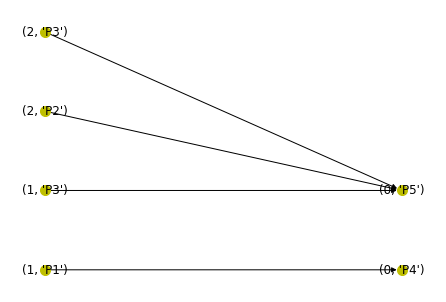

In [ ]:
#small example
G = nx.DiGraph() #plant graph
BOM=nx.DiGraph() #BOM: bill of materials
G.add_edges_from( [(1,0),(2,0)] )
#  工場グラフ
#  1 => 0
#  2 => 0

UB={} 
Capacity = {0: 300, 1: 500, 2: 200 }
Product  = {0: ['P4','P5'], 1:['P1','P3'], 2: ['P2','P3']}

BOM.add_weighted_edges_from([ ('P1','P4', 1), ('P2','P5',2),('P3','P5',1) ])

#Construct product graph（生産グラフ）
ProdGraph = nx.tensor_product(G,BOM)
#print(ProdGraph.edges())
Temp = ProdGraph.copy()
for (i,p) in Temp:
    if p not in Product[i]:
        ProdGraph.remove_node( (i,p) )
print("ProdGraph Nodes=",ProdGraph.nodes())
print("ProdGraph Edges=",ProdGraph.edges())

Pipeline, Demand= {}, {}

h, b ={},{}    #inventory cost, baclorder cost
prob = {1:0.005, 2:0.002, 0:0.001}  #disruption probability
TTR0 ={1:1, 2:5, 0:2}  #Time-To-Recovery
TTR = defaultdict(int)
for i in TTR0:
    TTR[i] = TTR0[i]

for n in ProdGraph:
    if n[0] > 0:
        h[n] = 1.
        b[n] = 1000.
    else:
        h[n] = 4.
        b[n] = 1000.
    Pipeline[n] =300.
    UB[n] = 1000000.
    if ProdGraph.out_degree(n)==0:
        Demand[n]=100.
R={}
for (u,v) in ProdGraph.edges():
    (i,p)=u
    (j,q)=v
    R[u,v]=BOM[p][q]['weight']
print("R=",R)
print("Demand=",Demand)

TotalDemand ={}

# 座標を得るためにSCMGraphにコピー
ProdGraph2 = SCMGraph()
ProdGraph2.add_nodes_from(ProdGraph.nodes())
ProdGraph2.add_edges_from(ProdGraph.edges())
pos3 = ProdGraph2.layout()
nx.draw(ProdGraph2, pos=pos3, with_labels=True, node_color="y", node_size=100)

R= {((1, 'ABX'), (6, 'CFG1')): 1, ((1, 'ABX'), (7, 'CFG2')): 1, ((1, 'ABX'), (8, 'CFG3')): 1, ((1, 'ABN'), (6, 'CFG1')): 1, ((1, 'ABN'), (7, 'CFG2')): 1, ((1, 'ABN'), (8, 'CFG3')): 1, ((6, 'CFG1'), (10, 'F_CFG1')): 1, ((6, 'CFG1'), (11, 'F_CFG1')): 1, ((7, 'CFG2'), (11, 'F_CFG2')): 1, ((7, 'CFG2'), (12, 'F_CFG2')): 1, ((8, 'CFG3'), (12, 'F_CFG3')): 1, ((8, 'CFG3'), (13, 'F_CFG3')): 1, ((9, 'CFG4'), (10, 'F_CFG4')): 1, ((9, 'CFG4'), (13, 'F_CFG4')): 1, ((2, 'GHY'), (6, 'CFG1')): 1, ((2, 'GHY'), (7, 'CFG2')): 1, ((2, 'GHY'), (8, 'CFG3')): 2, ((2, 'GHY'), (9, 'CFG4')): 1, ((3, 'KIU'), (6, 'CFG1')): 1, ((3, 'KIU'), (8, 'CFG3')): 1, ((4, 'PFR'), (6, 'CFG1')): 1, ((4, 'PFR'), (8, 'CFG3')): 1, ((5, 'JKI1'), (7, 'CFG2')): 3, ((5, 'JKI2'), (6, 'CFG1')): 3, ((5, 'JKI3'), (6, 'CFG1')): 3, ((5, 'JKI3'), (8, 'CFG3')): 3, ((5, 'JKI3'), (9, 'CFG4')): 2}
Total Demand= {10: 0.18, 11: 0.21, 12: 0.2, 13: 0.21}


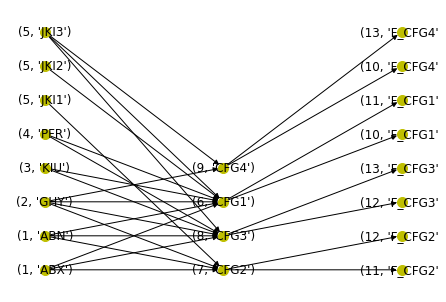

In [ ]:
#Golanyの例題 (MIT)
import networkx as nx

G = nx.DiGraph() #plant graph
BOM=nx.DiGraph() #BOM: bill of materials

#  工場グラフ
layer1 = [1,2,3,4,5]
layer2 = [6,7,8,9]
layer3 = [10,11,12,13] 
G.add_edges_from( [ (i,j) for i in layer1 for j in layer2] )
G.add_edges_from( [ (i,j) for i in layer2 for j in layer3] )
#len(G.edges())

bom_matrix = [[1,1,1,0],
              [1,1,1,0],
              [1,1,2,1],
              [1,0,1,0],
              [1,0,1,0],
              [0,3,0,0],
              [3,0,0,0],
              [3,0,3,2]]
children = ["ABX", "ABN", "GHY","KIU","PFR","JKI1","JKI2","JKI3"]
parents = [ f"CFG{i}" for i in range(1,5)]
arcs = []
for i,c in enumerate(children):
    for j,p in enumerate(parents):
        if bom_matrix[i][j]>0:
            arcs.append( (c,p,bom_matrix[i][j])  )
for p in parents:
    arcs.append( (p,"F_"+p,1) )
BOM.add_weighted_edges_from( arcs )
#len(BOM.edges())
UB={} 
Product  = {1: ["ABX", "ABN"], 2:["GHY"], 3: ["KIU"], 4:["PFR"], 5:["JKI1","JKI2","JKI3"],
            6:['CFG1'],7:['CFG2'], 8:['CFG3'],9:['CFG4'],
            10:['F_CFG1','F_CFG4'],11:['F_CFG1','F_CFG2'], 12:['F_CFG2','F_CFG3'],13:['F_CFG3','F_CFG4']}

#Construct product graph（生産グラフ）
ProdGraph = nx.tensor_product(G,BOM)
#print(ProdGraph.edges())
Temp = ProdGraph.copy()
for (i,p) in Temp:
    if p not in Product[i]:
        ProdGraph.remove_node( (i,p) )
#print("ProdGraph Nodes=",ProdGraph.nodes())
#print("ProdGraph Edges=",ProdGraph.edges())
#ProdGraph.edges()

Pipeline, Demand= {}, {}
for n in ProdGraph:
    Pipeline[n] = random.random()
    UB[n] = 10 #random.randint(1,10)
Demand ={}
TotalDemand ={10:0.18, 11: 0.21, 12:0.2, 13:0.21 }
R={}
for (u,v) in ProdGraph.edges():
    (i,p)=u
    (j,q)=v
    R[u,v]=BOM[p][q]['weight']
print("R=",R)
print("Total Demand=",TotalDemand)
#容量をalpha倍に増大させる
alpha = 1.2
Capacity0 = {1: 1.2, 2: 0.9, 3: 0.5, 4:0.5, 5:2.4, 6:0.2, 7:0.4, 8:0.3, 9:0.2 }
Capacity ={}
for i in Capacity0:
    Capacity[i] = Capacity0[i]*alpha

hlist=[31,30,32,29,30,30,33,31,50,550,600,505]
ProdList=[]
h0, b0 = {}, {}
h, b = {}, {}
for p in Product:
    ProdList.extend(Product[p])
for i, p in enumerate(ProdList):
    try:
        h0[p] = hlist[i]    #inventory cost
        b0[p] = h0[p]*100.
    except:
        break
for p in ['CFG1','CFG2','CFG3','CFG4']:
    h0["F_"+p] = h0[p]
    b0["F_"+p] = b0[p]
                                  
for (i,p) in ProdGraph:
    h[i,p] = h0[p]
    b[i,p] = b0[p]
  
prob = {1: 0.0667, 2: 0.1333, 3: 0.2, 4:0.1667, 5:0.0667, 6:0.0667, 7:0.1667, 8:0.0667, 9:0.0667 }  #disruption probability
TTR0 =  {1: 1, 2: 1.2, 3: 1.4, 4:1.6, 5:1.8, 6:2, 7:2.2, 8:2.4, 9:2.6 }  #Time-To-Recovery
TTR = defaultdict(int)
for i in TTR0:
    TTR[i] = TTR0[i]
# 座標を得るためにSCMGraphにコピー
ProdGraph2 = SCMGraph()
ProdGraph2.add_nodes_from(ProdGraph.nodes())
ProdGraph2.add_edges_from(ProdGraph.edges())
pos3 = ProdGraph2.layout()
nx.draw(ProdGraph2, pos=pos3, with_labels=True, node_color="y", node_size=100)

## Gurobiモデル

In [ ]:
#| include: false
#TotalDemandを追加したモデル
survival_time = []
tempUB = {}
ProdGraph = ProdGraph2
for s in ProdGraph:
    # for each scenario s
    for n in ProdGraph:
        tempUB[n] = UB[n]
    tempUB[s] = 0.0
    #print("Scenario", s)

    model = Model()
    tn = model.addVar(name='tn', vtype='C')
    u, y = {}, {}
    for i, j in ProdGraph.edges():
        y[i, j] = model.addVar(name='y({0},{1})'.format(i, j))
    for j in ProdGraph:
        u[j] = model.addVar(name='u({0})'.format(j), ub=tempUB[j])

    model.update()
    model.setObjective(tn, GRB.MAXIMIZE)

    # 生産量と入庫輸送量との関係
    for j in ProdGraph:
        if ProdGraph.in_degree(j) > 0:
            (plant, prod) = j
            for child in BOM.predecessors(prod):
                model.addConstr(u[j] <= quicksum((1/float(R[i, j])) * y[i, j]
                                                 for i in ProdGraph.predecessors(j)
                                                 if i[1] == child),
                                name=f"BOM{j}_{child}")

    # 生産量と出庫輸送量の関係
    for i in ProdGraph:
        if ProdGraph.out_degree(i) > 0:
            model.addConstr(quicksum(y[i, j] for j in ProdGraph.successors(i))
                            <= u[i] + Pipeline[i], name= f"BOM2_{i}")

    # 需要満足条件1
    for j in Demand:
        model.addConstr(u[j]+I[j] >= Demand[j]*tn, name=f"Demand{j}")

    # 需要満足条件2
    for f in TotalDemand:
        model.addConstr(quicksum( u[f,p] for p in Product[f]) >= TotalDemand[f]*tn, name=f"TotalDemand{f}")
        
    # 工場の生産容量制約
    for f in Capacity:
        model.addConstr(quicksum(u[f, p] for p in Product[f]) <= Capacity[f]*tn,
                        name=f"Capacity{f}")

    #model.addConstr(tn==1)
    #print(model)
    model.Params.OutputFlag = False
    model.optimize()
    #print('tn=', tn.X)
    survival_time.append(int(tn.X*10)/10)
    #break
# fig = draw_scrm(ProdGraph, survival_time, Pipeline, UB, pos3)
# plotly.offline.plot(fig);

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mikiokubo/Library/Caches/pypoetry/virtualenvs/scmopt-KVX_UVCf-py3.8/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/69/5y96sdc94jxf6khgc8mlmxrr0000gn/T/b6895e33ecef4a81808bf463db606d21-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/69/5y96sdc94jxf6khgc8mlmxrr0000gn/T/b6895e33ecef4a81808bf463db606d21-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 57 COLUMNS
At line 185 RHS
At line 238 BOUNDS
At line 287 ENDATA
Problem MODEL has 52 rows, 48 columns and 126 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 25 (-27) rows, 20 (-28) columns and 70 (-56) elements
Perturbing problem by 0.001% of 0.83759649 - largest nonzero change 0.00037034434 ( 0.044215125%) - largest zero change 0.00027620064
0  Obj -0 Dual inf 0.83722515 (1)
17  Obj 3.2318824
Opti

## 期待値最小化Gurobiモデル

In [ ]:
#| include: false
#期待値最小化モデル
#シナリオ生成
from itertools import combinations

V = list(Capacity.keys()) 
K_max = 2 #同時途絶確率の組み合わせの上限
for k in range(2,K_max+1):
    for comb in combinations(V,k):
        prob_ = 1.
        for i in comb:
            prob_ *= prob[i]
        prob[ comb ] = prob_
#シナリオごとの　TTR, TMAXの計算
TMAX ={} 
for s in prob:
    max_ttr = 0
    if hasattr(s, "__iter__"):
        for i in s: #シナリオで途絶する工場
            TTR[i,s] = TTR[i]
            max_ttr = max(TTR[i], max_ttr)
        TMAX[s] = max_ttr
    else: #途絶ノードが1つ
        TTR[s,s] = TTR[s]
        TMAX[s] = TTR[s] 
        
model = Model()
u, y = {}, {}
I, B ={},{}

for i, j in ProdGraph.edges():
    for s in prob:
        y[i, j, s] = model.addVar(name=f'y({i},{j},{s})')
for j in ProdGraph:
    I[j] = model.addVar(name=f'I({j})')
    for s in prob:
        B[j,s] = model.addVar(name=f"B({j},{s})")
        u[j,s] = model.addVar(name=f'u({j},{s})', ub=UB[j])
                    
model.update()
model.setObjective(quicksum(h[i]*I[i] for i in ProdGraph)+
                   quicksum(prob[s]*b[i]*B[i,s] for i in ProdGraph for s in prob), GRB.MINIMIZE)

# 生産量と入庫輸送量との関係
for s in prob:
    for j in ProdGraph:
        if ProdGraph.in_degree(j) > 0:
            (plant, prod) = j
            for child in BOM.predecessors(prod):
                model.addConstr(u[j,s] <= quicksum((1/float(R[i, j])) * y[i, j, s]
                                                 for i in ProdGraph.predecessors(j)
                                                 if i[1] == child),
                                name=f"BOM{j}_{child}_{s}")

# 生産量と出庫輸送量の関係
for s in prob:
    for i in ProdGraph:
        if ProdGraph.out_degree(i) > 0:
            model.addConstr(quicksum(y[i, j, s] for j in ProdGraph.successors(i))
                            <= u[i,s] + I[i], name= f"BOM2_{i}_{s}")

# 需要満足条件1
for s in prob:
    for j in Demand:
        model.addConstr(u[j,s]+I[j]+B[j,s] >= Demand[j]*TMAX[s], name=f"Demand{j}_{s}")

# 需要満足条件2
for s in prob:
    for f in TotalDemand:
        model.addConstr(quicksum( u[(f,p),s] +I[f,p] + B[(f,p),s] for p in Product[f])>= TotalDemand[f]*TMAX[s], name=f"TotalDemand{f}_{s}")

# 工場の生産容量制約
for s in prob:
    for f in Capacity:
        model.addConstr(quicksum(u[ (f, p), s] for p in Product[f]) <= Capacity[f]* max((TMAX[s]-TTR[f,s]),0),
                        name=f"Capacity{f}_{s}")

#print(model)
#model.Params.OutputFlag = False
model.optimize()
#print('tn=', tn.X)
survival_time =[]
for i in I:
    survival_time.append(I[i].X*10.)
Pipeline ={}
for i in h:
    Pipeline[i] = h[i]*10.
# fig = draw_scrm(ProdGraph, survival_time, Pipeline, UB, pos3)
# plotly.offline.plot(fig);

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mikiokubo/Library/Caches/pypoetry/virtualenvs/scmopt-KVX_UVCf-py3.8/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/69/5y96sdc94jxf6khgc8mlmxrr0000gn/T/b90e944d741f4ab0b514408d7c4d1791-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/69/5y96sdc94jxf6khgc8mlmxrr0000gn/T/b90e944d741f4ab0b514408d7c4d1791-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2345 COLUMNS
At line 9611 RHS
At line 11952 BOUNDS
At line 14988 ENDATA
Problem MODEL has 2340 rows, 3035 columns and 6345 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 708 (-1632) rows, 901 (-2134) columns and 2632 (-3713) elements
Perturbing problem by 0.001% of 11000 - largest nonzero change 0.0084712843 ( 0.027326723%) - largest zero change 0.0084438986
0  Obj 0 Primal inf 74.39982 (180)
89  Obj 18

In [ ]:
survival_time

[0.0,
 0.0,
 1.7000000000000002,
 0.0,
 3.84,
 0.0,
 1.08,
 0.0,
 0.0,
 0.0,
 0.0,
 7.08,
 2.88,
 0.0,
 2.44,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
sum_ =0
for i in I:
    print(i, I[i].X)
    sum_ += h[i]*I[i].X/100.
print("Total Invenory=", sum_)
#model.write("tmp.lp")   
print("Backorder")
for j in B:
    if B[j].X>0:
        print(j,B[j].X)

(1, 'ABX') 0.0
(1, 'ABN') 0.0
(6, 'CFG1') 0.17
(7, 'CFG2') 0.0
(8, 'CFG3') 0.384
(9, 'CFG4') 0.0
(2, 'GHY') 0.108
(3, 'KIU') 0.0
(4, 'PFR') 0.0
(5, 'JKI1') 0.0
(5, 'JKI2') 0.0
(5, 'JKI3') 0.708
(10, 'F_CFG1') 0.288
(10, 'F_CFG4') 0.0
(11, 'F_CFG1') 0.244
(11, 'F_CFG2') 0.0
(12, 'F_CFG2') 0.0
(12, 'F_CFG3') 0.0
(13, 'F_CFG3') 0.0
(13, 'F_CFG4') 0.0
Total Invenory= 2.90904
Backorder
((13, 'F_CFG4'), (8, 9)) 0.09


## ベンチマーク問題例からデータを生成する関数 data_generation_for_scrm

3つの有向グラフが必要となる。

1. ベンチマークのグラフである部品展開表 BOM
2. 工場グラフ: 各段階に n_plnts 個の工場があり、次段階に確率 prob で枝があるグラフ
3. 生産グラフ： 各段階の工場にその段階の品目が n_flex 個割り振られるように設定して得られるグラフ；工場と製品の集合のテンソル積から、工場で生産できない製品を表す点を除くことによって得ることができる。

引数：

- BOM : ベンチマーク問題例から読み込まれた部品展開表 (BOM) を表すNetworkXの有向グラフ
- n_plnts : ベンチマークのBOMの各階層ごとの工場数（既定値は3） 
- n_flex : 各工場で生産可能な製品の数；生産の柔軟性を表す。どの工場でも生産されない製品は最後の工場で生産する。（既定値は2）
- prob : 工場グラフにおける枝の発生確率；同じ順番の点間には枝をはり、それ以外の枝をこの確率で発生させる。（既定値は0.5）
- capacity_factor : 工場の生産容量を決めるパラメータ。総需要量にこの値を乗じた量が、各工場の容量になる。（既定値は1.0） 
- production_factor : 生産量上限を決めるパラメータ。総需要量にこの値を乗じた量が、各地点の生産量上限になる。（既定値は1.0） 
- pipeline_factor : パイプライン在庫量を決めるパラメータ。総需要量に生産時間の値とこの値を乗じた量が、各地点のパイプライン在庫量になる。（既定値は1.0） 
- seed : 乱数の種　（既定値は1）

返値：

- Demand : 需要地点の需要を入れた辞書
- total_demand : 総需要量
- UB :  各点での生産量上限を入れた辞書
- Capacity : 工場の生産容量を入れた辞書
- Pipeline : 各点でのパイプライン在庫量を入れた辞書
- R : 親製品を生産するために必要な子製品の数を入れた辞書
- Product : 工場で生産可能な製品を入れた辞書
- G : 工場グラフ
- ProdGraph : 生産グラフ
- pos2 : 工場グラフの点の座標を入れた辞書
- pos3 : 生産グラフの点の座標を入れた辞書

In [ ]:
#| export
def data_generation_for_scrm(BOM, n_plnts = 3, n_flex = 2, prob = 0.5, capacity_factor=1.0,
                             production_factor=1.0, pipeline_factor =1.0, seed = 1):
    """
    ベンチマーク問題例から、データを生成する関数
    """
    random.seed(seed)

    # 点の深さと、各深さに含まれる製品のリストを作る
    depth_dic = nx.get_node_attributes(BOM, "relDepth")  # map node to depth (str)
    depth_set = set(depth_dic.values())
    depth = len(depth_set)
    ProdInDepth = [[] for d in range(depth)]
    for i in depth_dic:
        d = int(depth_dic[i])
        # print(i,d)
        ProdInDepth[d].append(i)

    # 工場グラフを生成（各深さに n_plnts個の工場を配置、製品をランダムにn_flex個配置、枝はprobではる）
    G = nx.DiGraph()  # Plant Graph
    Product = {}
    pos2 = {}
    NodeInDepth = [[] for d in range(depth)]
    id_ = 0
    for d in range(depth):
        added_prod = []
        for i in range(n_plnts):
            G.add_node(id_)
            pos2[id_] = (depth-d, n_plnts-i)
            NodeInDepth[d].append(id_)
            Product[id_] = random.sample(
                ProdInDepth[d], min(n_flex, len(ProdInDepth[d])))
            added_prod.extend(Product[id_])
            id_ += 1
        # どの工場でも生産されていない製品があれば、それを加える。
        all_prod = set(ProdInDepth[d])
        added_prod_set = set(added_prod)
        Product[id_ - 1].extend(all_prod-added_prod_set)

    for d in range(1, depth):
        for count1, i in enumerate(NodeInDepth[d]):
            for count2, j in enumerate(NodeInDepth[d-1]):
                if count1 == count2:
                    G.add_edge(i, j)
                elif random.random() <= prob:
                    G.add_edge(i, j)

    # Construct product graph（生産グラフの生成）
    ProdGraph = nx.tensor_product(G, BOM)
    Temp = ProdGraph.copy()
    for (i, p) in Temp:
        if p not in Product[i]:
            ProdGraph.remove_node((i, p))

    # 座標を得るためにSCMGraphにコピー
    ProdGraph2 = SCMGraph()
    ProdGraph2.add_nodes_from(ProdGraph.nodes())
    ProdGraph2.add_edges_from(ProdGraph.edges())
    pos3 = ProdGraph2.layout()

    Pipeline, Demand, UB = {}, {}, {}
    Capacity = {}
    total_demand = 0.
    for n in ProdGraph:
        if BOM.out_degree(n[1]) == 0:
            Demand[n] = float(BOM.nodes[n[1]]["avgDemand"])
            total_demand += Demand[n]

    for i in G:
        Capacity[i] = total_demand * capacity_factor  # 工場の容量
    for n in ProdGraph:
        UB[n] = total_demand *production_factor
        Pipeline[n] = float(BOM.nodes[n[1]]["stageTime"])*total_demand * pipeline_factor

    R = {}
    for (u, v) in ProdGraph.edges():
        (i, p) = u
        (j, q) = v
        R[u, v] = 1

    return Demand, total_demand, UB, Capacity, Pipeline, R, Product, G, ProdGraph2, pos2, pos3

### data_generation_for_scrmの使用例

inventoryモジュールの read_willems関数を用いてベンチマーク問題を読み込む。
返値は、部品展開表 BOM と点の位置を表す辞書 pos である。


In [ ]:
#BOM, pos = read_willems(file_name="01") # ベンチマーク問題例からBOMデータを読み込む
Demand, total_demand, UB, Capacity, Pipeline, R, Product, G, ProdGraph2, pos2, pos3 = data_generation_for_scrm(BOM, n_plnts = 3, n_flex = 2, prob = 0.5, capacity_factor=1.0,
                             production_factor=1.0, pipeline_factor =0.5, seed = 1)

## データ構造をデータフレームに変換する関数 make_df_for_scrm

In [ ]:
#| export
def  make_df_for_scrm(G,Demand,UB,Capacity,Pipeline,BOM,fn):
    col_name = ["child", "parent", "units"]
    col_list = {i: [] for i in col_name}
    for (i,j) in BOM.edges():
        col_list["child"].append(i)
        col_list["parent"].append(j)
        col_list["units"].append(1)

    bom_df = pd.DataFrame(col_list, columns= col_name)
    bom_df.to_csv(folder+"bom"+fn+".csv")

    col_name =["from_node", "to_node", "kind"]
    col_list = {i: [] for i in col_name}
    for (i,j) in G.edges():
        col_list["from_node"].append(i)
        col_list["to_node"].append(j)
        col_list["kind"].append("plnt-plnt")

    trans_df = pd.DataFrame(col_list, columns= col_name)
    trans_df.to_csv(folder+"trans"+fn+".csv")

    col_name =["plnt", "prod", "ub", "pipeline", "demand"]
    col_list = {i: [] for i in col_name}
    for i,p in Pipeline:
        col_list["plnt"].append(i)
        col_list["prod"].append(p)
        col_list["ub"].append(UB[i,p])
        col_list["pipeline"].append(Pipeline[i,p])
        if (i,p) in Demand:
            col_list["demand"].append(Demand[i,p])
        else:
            col_list["demand"].append(None)
    plnt_prod_df = pd.DataFrame(col_list, columns= col_name)
    plnt_prod_df.to_csv(folder+"plnt_prod"+fn+".csv")
    col_name =["name", "ub"]
    col_list = {i: [] for i in col_name}
    for i in Capacity:
        col_list["name"].append(i)
        col_list["ub"].append(Capacity[i])
    plnt_df = pd.DataFrame(col_list, columns= col_name)
    plnt_df.to_csv(folder+"plnt"+fn+".csv")

### すべてのデータをデータフレームに変換

In [ ]:
# for i in range(1, 39):
#     fn = str(i)
#     if len(fn) == 1:
#         fn = "0"+fn

#     BOM, pos = read_willems(file_name=fn)
#     Demand, total_demand, UB, Capacity, Pipeline, R, Product, G, ProdGraph2, pos2, pos3 = data_generation_for_scrm(BOM, n_plnts = 3, n_flex = 2, prob = 0.5, capacity_factor=1.0,
#                              production_factor=1.0, pipeline_factor =1.0, seed = 1)
#     make_df_for_scrm(G,Demand,UB,Capacity,Pipeline,BOM,fn)

### データフレームから読み込みデータ構造を組み立てる関数 prepare

In [ ]:
#| export
def prepare(fn, folder):
    bom_df = pd.read_csv(folder+"bom"+fn+".csv", index_col=0)
    plnt_df = pd.read_csv(folder+"plnt"+fn+".csv", index_col=0)
    plnt_prod_df = pd.read_csv(folder+"plnt_prod"+fn+".csv", index_col=0)
    trans_df = pd.read_csv(folder+"trans"+fn+".csv", index_col=0)

    #Demand, UB, Pipeline
    Demand, UB, Pipeline= {}, {}, {}
    Product ={ i:[]  for i in list(plnt_df.name) }
    for row in plnt_prod_df.itertuples():
        if np.isnan(row.demand):
            pass
        else:
            Demand[row.plnt, row.prod] = row.demand
        UB[row.plnt, row.prod] = row.ub
        Pipeline[row.plnt, row.prod] = row.pipeline
        Product[row.plnt].append(row.prod)

    Capacity ={ }
    for row in plnt_df.itertuples():
        Capacity[row.name] = row.ub

    #BOM
    BOM = SCMGraph()
    for row in bom_df.itertuples():
        BOM.add_edge(row.child, row.parent, weight=row.units)
    pos = BOM.layout()
    #Plant Transportaion Graph
    G = SCMGraph()
    for row in trans_df.itertuples():
        G.add_edge(row.from_node, row.to_node)
    pos2 = G.layout()
    # Construct product graph（生産グラフの生成）
    ProdGraph = nx.tensor_product(G, BOM)
    Temp = ProdGraph.copy()
    for (i, p) in Temp:
        if p not in Product[i]:
            ProdGraph.remove_node((i, p))

    # 座標を得るためにSCMGraphにコピー
    ProdGraph2 = SCMGraph()
    ProdGraph2.add_nodes_from(ProdGraph.nodes())
    ProdGraph2.add_edges_from(ProdGraph.edges())
    pos3 = ProdGraph2.layout()

    R = {}
    for (u, v) in ProdGraph.edges():
        (i, p) = u
        (j, q) = v
        R[u, v] = BOM[p][q]["weight"]

    return Demand, UB, Capacity, Pipeline, R, BOM, Product, G, ProdGraph2, pos, pos2, pos3, bom_df, plnt_df, plnt_prod_df, trans_df

#### prepare関数の使用例

In [ ]:
fn = "01"
Demand, UB, Capacity, Pipeline, R, BOM, Product, G, ProdGraph2, pos, pos2, pos3, bom_df, plnt_df, plnt_prod_df, trans_df = prepare(fn, folder=folder)

## 描画関数 draw_graph


In [ ]:
#| export
def draw_graph(G, pos, title="", size=30, color="Yellow"):
    """
    グラフをPlotlyで描画する関数
    """

    x_, y_, text_ = [], [], []
    for idx, i in enumerate(G):
        x_.append(pos[i][0])
        y_.append(pos[i][1])
        text_.append(str(i))

    node_trace = go.Scatter(
        x=x_,
        y=y_,
        mode='markers',
        text=text_,
        marker=dict(
            size=size,
            color=color
        ),
        hoverinfo="text",
        name="nodes",
        showlegend=False
    )

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines',
        name="edges",
        showlegend=False
    )

    layout = go.Layout(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                       yaxis=dict(showgrid=False, zeroline=False,
                                  showticklabels=False),
                       title=title)

    data = [node_trace, edge_trace]
    fig = go.Figure(data, layout)
    return fig

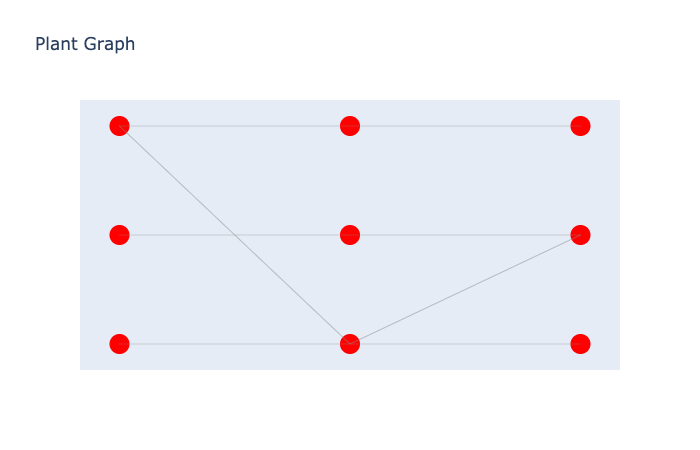

In [ ]:
#| echo: false
# fig = draw_graph(G, pos2, "Plant Graph", color ="Red", size=20)
# plotly.offline.plot(fig)
Image("../figure/plant_graph.png")

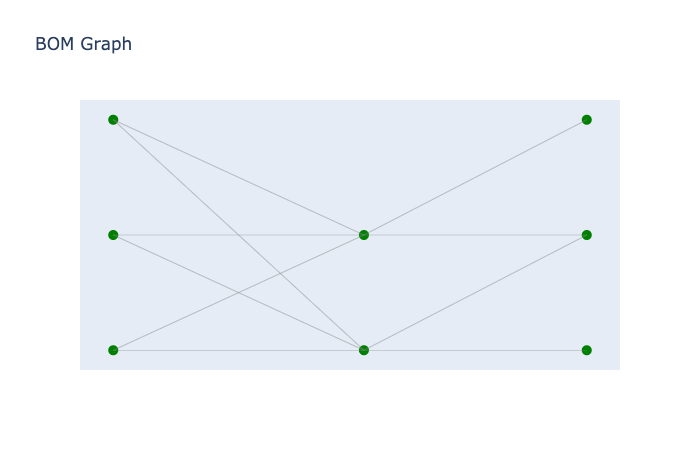

In [ ]:
#| echo: false
#fig = draw_graph(BOM, pos, "BOM Graph", color ="Green", size=10)
#plotly.offline.plot(fig)
Image("../figure/bom.png")

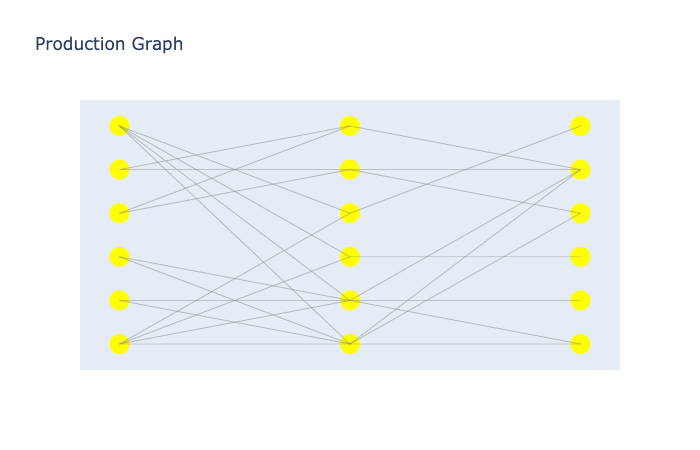

In [ ]:
#| echo: false
#fig = draw_graph(ProdGraph, pos3, "Production Graph", color ="Yellow", size=20)
#plotly.offline.plot(fig)
Image("../figure/production_graph.png")

## リスク分析問題を解く関数

引数：

- Demand : 需要地点の需要を入れた辞書
- UB :  各点での生産量上限を入れた辞書
- Capacity : 工場の生産容量を入れた辞書
- Pipeline : 各点でのパイプライン在庫量を入れた辞書
- R : 親製品を生産するために必要な子製品の数を入れた辞書
- Product : 工場で生産可能な製品を入れた辞書
- ProdGraph : 生産グラフ
- BOM : 部品展開表 (BOM) を表すグラフ

返値：
- survival_time: 各点の余裕生存期間（点の途絶時に品切れがおきない最大の期間）を入れたリスト

In [ ]:
#| export
def solve_scrm(Demand, UB, Capacity, Pipeline, R, Product, ProdGraph, BOM):
    """
    リスク分析問題を解く関数
    """
    survival_time = []
    tempUB = {}
    for s in ProdGraph:
        # for each scenario s
        for n in ProdGraph:
            tempUB[n] = UB[n]
        tempUB[s] = 0.0
        #print("Scenario", s)

        model = Model()
        tn = model.addVar(name='tn', vtype='C')
        u, y = {}, {}
        for i, j in ProdGraph.edges():
            y[i, j] = model.addVar(name='y({0},{1})'.format(i, j))
        for j in ProdGraph:
            u[j] = model.addVar(name='u({0})'.format(j), ub=tempUB[j])

        model.update()
        model.setObjective(tn, GRB.MAXIMIZE)

        # 生産量と入庫輸送量との関係
        for j in ProdGraph:
            if ProdGraph.in_degree(j) > 0:
                (plant, prod) = j
                for child in BOM.predecessors(prod):
                    model.addConstr(u[j] <= quicksum((1/float(R[i, j])) * y[i, j]
                                                     for i in ProdGraph.predecessors(j)
                                                     if i[1] == child),
                                    name=f"BOM{j}_{child}")

        # 生産量と出庫輸送量の関係
        for i in ProdGraph:
            if ProdGraph.out_degree(i) > 0:
                model.addConstr(quicksum(y[i, j] for j in ProdGraph.successors(i))
                                <= u[i] + Pipeline[i], name="BOM2_{0}".format(i))

        # 需要満足条件
        for j in Demand:
            model.addConstr(u[j] >= Demand[j]*tn, name="Demand{0}".format(j))

        # 工場の生産容量制約
        for f in Capacity:
            model.addConstr(quicksum(u[f, p] for p in Product[f]) <= Capacity[f]*tn,
                            name="Capacity{0}".format(f))

        # print(model)
        model.Params.OutputFlag = False
        model.optimize()
        #print('tn=', tn.X)
        survival_time.append(tn.X)
    return survival_time

### solve_scrm関数の使用例

In [ ]:
#Demand, UB, Capacity, Pipeline, R, BOM, Product, G, ProdGraph, pos, pos2, pos3, bom_df, plnt_df, plnt_prod_df, trans_df = prepare("09")
# survival_time = solve_scrm(Demand, UB, Capacity, Pipeline, R, Product, ProdGraph, BOM)
#plnt_prod_df["survival_time"] = survival_time
#plnt_prod_df.head()

## リスク分析ネットワークを描画する関数 draw_scrm

引数：

- ProdGraph : 生産グラフ
- survival_time: 各点の余裕生存期間（点の途絶時に品切れがおきない最大の期間）を入れたリスト
- Pipeline : 各点でのパイプライン在庫量を入れた辞書
- UB :  各点での生産量上限を入れた辞書
- pos3 : 生産グラフの点の座標を入れた辞書

返値：

- リスク分析ネットワークの図オブジェクト


In [ ]:
#| export
def draw_scrm(ProdGraph, survival_time, Pipeline, UB, pos3):
    """
    リスク分析ネットワークを描画する関数
    """
    #ST = np.array(survival_time)
    #scaledST = np.log(ST/(ST.max()+0.001))
    
    ST = np.array(survival_time)
    scaledST = np.log(ST+1.001)

    size_ = scaledST*30 + 1.

    x_, y_, text_ = [],[],[]
    color_ =[]
    for i,n in enumerate(ProdGraph):
        x_.append( pos3[n][0] )
        y_.append( pos3[n][1] )
        text_.append( str(n) + " 生存期間:" +str(survival_time[i]) + " パイプライン在庫:" + str(Pipeline[n]) + " 生産量上限:" + str(UB[n])  )
        color_.append( Pipeline[n])

    node_trace = go.Scatter(
        x = x_,
        y = y_,
        mode = 'markers',
        text= text_,
        hoverinfo="text",
        marker= dict(size= size_,
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                colorscale="Hot",
                reversescale=True,
                color= color_,
                colorbar=dict(
                        thickness=15,
                        title='Pipeline Inventory',
                        xanchor='left',
                        titleside='right'
                        ),
                ),
         name = "nodes",
         showlegend=False
    )

    edge_x = []
    edge_y = []
    for edge in ProdGraph.edges():
        x0, y0 = pos3[edge[0]]
        x1, y1 = pos3[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines',
        name = "edges",
        showlegend=False
        )

    layout=go.Layout(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    title="Risk Analysis Network (点の大きさ: 途絶時の生存期間, 色： パイプライン在庫)")

    data = [node_trace, edge_trace]
    fig = go.Figure(data,layout)
    return fig

In [ ]:
# fig = draw_scrm(ProdGraph, survival_time, Pipeline, UB, pos3)
# plotly.offline.plot(fig);

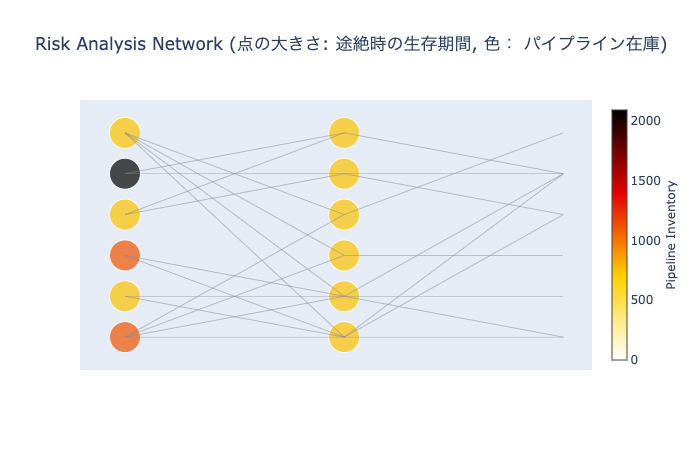

In [ ]:
#| echo: false
Image("../figure/risk_analysis_network.png")